# Retail Business Performance & Profitability Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Load & Clean Data

In [7]:
df = pd.read_csv("superstore_cleaned_dataset.csv")

df['Order_Date'] = pd.to_datetime(df['Order_Date'],dayfirst=True, errors='coerce')
df['Profit_Margin'] = df['Profit'] / df['Sales'] * 100
df['Inventory_Days'] = (df['Quantity'] / df['Sales']) * 30 

In [9]:
df.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,...,Product_Name,Sales,Quantity,Discount,Profit,Order_Year,Order_Month,Order_Quarter,Profit_Margin,Inventory_Days
0,1,CA-2016-152156,2016-11-08,11-11-2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bush Somerset Collection Bookcase,261.959992,2,0.00,41.9136,2016,11,4,16.000001,0.229043
1,2,CA-2016-152156,2016-11-08,11-11-2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.940002,3,0.00,219.5820,2016,11,4,30.000000,0.122961
2,3,CA-2016-138688,2016-06-12,16-06-2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Self-Adhesive Address Labels for Typewriters b...,14.620000,2,0.00,6.8714,2016,6,2,47.000000,4.103967
3,4,US-2015-108966,2015-10-11,18-10-2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Bretford CR4500 Series Slim Rectangular Table,957.577515,5,0.45,-383.0310,2015,10,4,-39.999999,0.156645
4,5,US-2015-108966,2015-10-11,18-10-2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Eldon Fold 'N Roll Cart System,22.368000,2,0.20,2.5164,2015,10,4,11.250000,2.682403


### 2. Correlation: Inventory vs Profitability

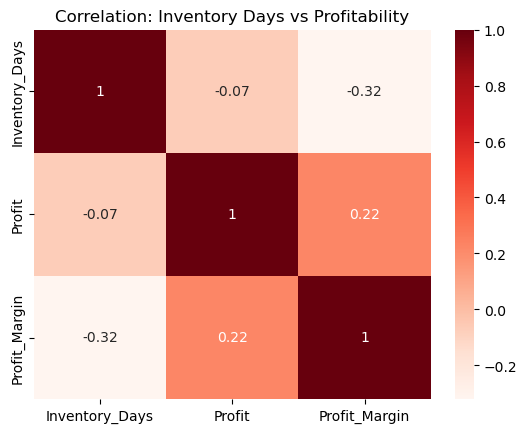

In [12]:
corr_matrix = df[['Inventory_Days','Profit','Profit_Margin']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="Reds")
plt.title("Correlation: Inventory Days vs Profitability")
plt.show()

### 3. Inventory Optimization (Slow-Moving & Overstocked)

In [15]:
df['Slow_Moving'] = df['Inventory_Days'] > df['Inventory_Days'].quantile(0.90)  
df['Overstocked'] = df['Quantity'] > df['Quantity'].quantile(0.75)

df['Action_Recommended'] = np.select(
    [
        (df['Slow_Moving']) & (df['Profit'] < 0),   # Slow-Moving Loss
        (df['Slow_Moving']) & (df['Profit'] >= 0),  # Slow-Moving Profit
        (df['Overstocked']) & (df['Profit'] < 0),   # Overstocked Loss
        (df['Overstocked']) & (df['Profit'] >= 0)   # Overstocked Profit
    ],
    [
        'Phase Out (with Discounting)',  
        'Bundle Promotions',
        'Liquidate Inventory',
        'Run Clearance Promotions'
    ],
    default='No Action Needed'
)

### Export actionable product list

In [18]:
df_actions = df[df['Action_Recommended'] != 'No Action'][
    ['Product_Name','Category','Sub_Category','Inventory_Days','Profit','Action_Recommended']
]
df_actions.to_csv("actionable_products.csv", index=False)

### 4. Top 10 slow-moving products

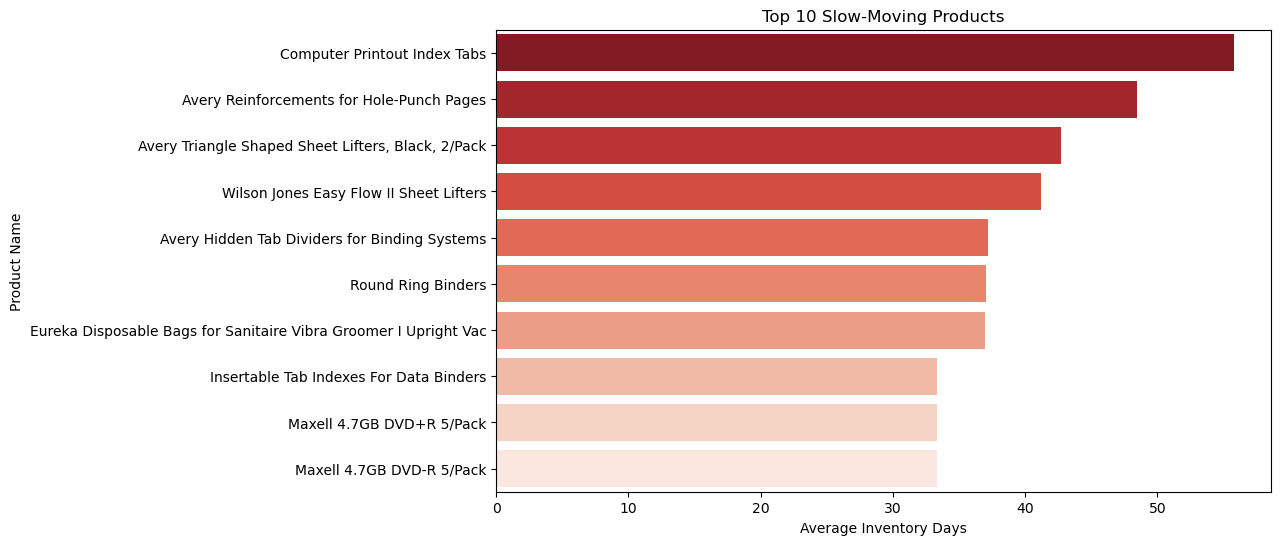

In [21]:
slow_moving_details = (
    df.groupby(['Category','Sub_Category','Product_Name'])['Inventory_Days']
      .mean()
      .reset_index()
      .sort_values('Inventory_Days', ascending=False)
      .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(x="Inventory_Days", y="Product_Name", hue="Product_Name",data=slow_moving_details,
            palette="Reds_r", dodge=False, legend=False)
plt.title("Top 10 Slow-Moving Products")
plt.xlabel("Average Inventory Days")
plt.ylabel("Product Name")
plt.show()

### 5. Seasonal Profitability

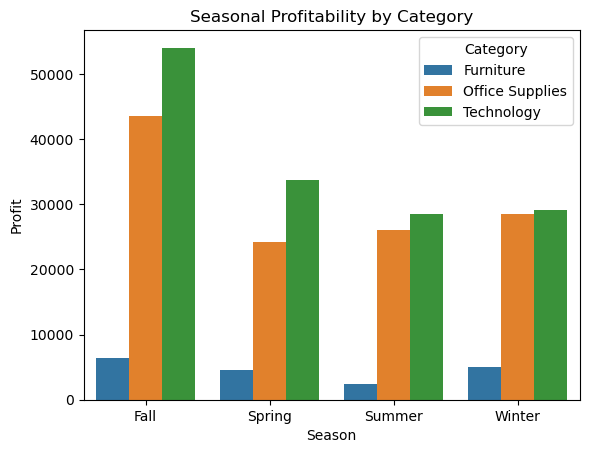

In [27]:
def get_season(date):
    m = date.month
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Order_Date'].apply(get_season)
seasonal = df.groupby(['Season', 'Category'])['Profit'].sum().reset_index()

sns.barplot(data=seasonal, x='Season', y='Profit', hue='Category')
plt.title("Seasonal Profitability by Category")
plt.show()

### 6. Final Export

In [30]:
df.to_csv('retail_analysis_output.csv', index=False)

### 7.Recommendations:

1. Phase out or discount loss-making slow-moving products; bundle profitable ones to improve turnover.
2. Liquidate or clear overstocked items (profitable or not) to free up working capital and reduce storage costs.
3. Focus seasonal strategies: boost profitable categories in peak seasons, and control losses in weak seasons.